# Random Forest and XGBoost on Amazon Food Reviews

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

1.  index
2.  Id
3.  ProductId - unique identifier for the product
4.  UserId - unqiue identifier for the user
5.  ProfileName
6.  HelpfulnessNumerator - number of users who found the review helpful
7.  HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
8.  Score - rating between 1 and 5
9.  Time - timestamp for the review
10. Summary - brief summary of the review
11. Text - text of the review
12. ProcessedText - Cleaned & Preprocessed Text of the review

**Objective: Given Amazon Food reviews, convert all the reviews into a vector using two techniques: **<br>
**1. Average W2V.**<br>
**2. Average TFIDF-W2V.**<br>

**Then perform following tasks under each technique:**<br>
**Task 1. Split train and test data in a ratio of 80:20.** <br>
**Task 2. Perform GridSearch Cross Validation to find optimal value of number of base models in Random Forest.**<br>
**Task 3. Apply Random Forest and report accuracy. Also check for train error.**<br>
**Task 4. Perform GridSearch Cross Validation to find optimal number of base models and optimal value of depth of decision tree base models in XGBoost. **<br>
**Task 5. Apply XGBoost and report accuracy. Also check for train error.**<br>

[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

Loading the data

SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently. Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
import gensim
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

In [4]:
connection = sqlite3.connect('FinalAmazonFoodReviewsDataset.sqlite')

In [5]:
data = pd.read_sql_query("SELECT * FROM Reviews", connection)

In [6]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut the pean...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,Positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...


In [7]:
data.shape

(364171, 12)

In [8]:
data["Score"].value_counts()

Positive    307061
Negative     57110
Name: Score, dtype: int64

In [9]:
def changingScores(score):
    if score == "Positive":
        return 1
    else:
        return 0

In [10]:
# changing score
# Positive = 1
# Negative = 0
actualScore = list(data["Score"])                                                                                         
positiveNegative = list(map(changingScores, actualScore)) #map(function, list of numbers)
data['Score'] = positiveNegative

In [11]:
#taking 10000 random samples
data = data.sample(n = 10000)

In [12]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
1771,2319,2525,B000NY4SZQ,A1IDF30FSGME1L,Shari,2,2,1,1283040000,Thomy Mustard Maniac,This is the best I've ever eaten. If you like...,this the best ive ever eaten you like mustard ...
307570,442577,478546,B000E3XCG2,A3N8XPE3QXZ62Q,"Connie L. Roberts ""Daeshii""",1,1,1,1185321600,"Oh, Yummy!!",I've always been a big fan of Zatarain's produ...,ive alway been big fan zatarain product and th...
309959,445341,481519,B004OY7FD8,A18F3YI8GZCIIY,Karmali,0,0,1,1340496000,Delicious crackers.,These are delicious crackers that taste very d...,these are delici cracker that tast veri delici...
183392,259085,280861,B000FFLHSY,A3JETXRRUHIOUH,rain21004,3,4,0,1271980800,Drain cleaner,Each time I have eaten these (either in a smoo...,each time have eaten these either smoothi mix ...
303846,436877,472419,B001F1U5WG,A1GZVRXW89KZST,kawtamer,1,1,1,1301011200,Great!,This is a GREAT alternative to coffee. I've tr...,this great altern coffe ive tri the vanilla nu...


In [13]:
data.shape

(10000, 12)

In [14]:
data["Score"].value_counts()

1    8456
0    1544
Name: Score, dtype: int64

In [15]:
data = data.sort_values('Time', axis=0, ascending=True)

In [16]:
Data = data

In [17]:
Data_Labels = data["Score"]

In [18]:
print(Data.shape)
print(Data_Labels.shape)

(10000, 12)
(10000,)


In [19]:
Data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
97415,138001,149770,B00004S1C5,A1KXONFPU2XQ5K,Stephanie Manley,8,8,1,965779200,Very easy to use,This are so much easier to use than the Wilson...,this are much easier use than the wilson past ...
238632,346030,374332,B00004CI84,AEPJYN0NAX9N4,Jody L. Schoth,0,0,1,1014163200,Excellent... Hilarious,Just hilarious... my favorite part is the dini...,just hilari favorit part the dine room scene w...
308591,443674,479736,B00005U2FA,A1UUIV2251UKHJ,S. McMillian,2,2,1,1052179200,Vacu Vin,Although this was a gift to use for keeping wi...,although this was gift use for keep wine have ...
267514,388413,419994,B0000A0BS5,A238V1XTSK9NFE,Andrew Lynn,46,59,0,1064361600,Not actually for use in espresso machines,Few things I'd like to point out:<p>1. &quot;...,few thing like point not roast it drink northe...
129891,184396,200021,B0000D9N5Q,A176XYKMRF1U8Q,Lance Arthur,0,0,1,1067990400,A small taste of heaven,Pierre Robert is similar to Brie but with a sm...,pierr robert similar brie but with smoother cr...


## 1. Avg W2V

In [20]:
i = 0
listOfSentences = []
for sentence in Data["ProcessedText"].values:
    subSentence = []
    for word in sentence.split():
        subSentence.append(word)
        
    listOfSentences.append(subSentence)

In [21]:
print(Data['ProcessedText'].values[0])
print("\n")
print(listOfSentences[0:2])
print("\n")
print(type(listOfSentences))

this are much easier use than the wilson past color color are vibrant and not taint the frost like some color can these are simpl use and not make mess onli complaint that did not find these year ago this must have you decor often


[['this', 'are', 'much', 'easier', 'use', 'than', 'the', 'wilson', 'past', 'color', 'color', 'are', 'vibrant', 'and', 'not', 'taint', 'the', 'frost', 'like', 'some', 'color', 'can', 'these', 'are', 'simpl', 'use', 'and', 'not', 'make', 'mess', 'onli', 'complaint', 'that', 'did', 'not', 'find', 'these', 'year', 'ago', 'this', 'must', 'have', 'you', 'decor', 'often'], ['just', 'hilari', 'favorit', 'part', 'the', 'dine', 'room', 'scene', 'with', 'all', 'the', 'sing', 'and', 'danc', 'classic', 'moment', 'not', 'miss', 'winona', 'rider', 'and', 'geena', 'davi', 'are', 'spectacular', 'this', 'movi', 'and', 'michael', 'keaton', 'unbeliev', 'funni', 'couldnt', 'stop', 'laugh', 'great', 'famili', 'movi', 'will', 'keep', 'you', 'stitch']]


<class 'list'>


In [22]:
w2vModel = gensim.models.Word2Vec(listOfSentences, size=300, min_count=5, workers=4)

In [23]:
# compute average word2vec for each review.
sentenceAsW2V = []
for sentence in listOfSentences:
    sentenceVector = np.zeros(300)
    TotalWordsPerSentence = 0
    for word in sentence:
        try:
            vect = w2vModel.wv[word]
            sentenceVector += vect
            TotalWordsPerSentence += 1
        except:
            pass
    if TotalWordsPerSentence!= 0:
        sentenceVector /= TotalWordsPerSentence
        sentenceAsW2V.append(sentenceVector)

print(type(sentenceAsW2V))
print(len(sentenceAsW2V))
print(len(sentenceAsW2V[0]))

<class 'list'>
10000
300


### Task 1. Split train and test data in a ratio of 80:20.

In [24]:
X_train_AvgW2V, X_test_AvgW2V, Y_train_labels_AvgW2V, Y_test_labels_AvgW2V = train_test_split(sentenceAsW2V, Data_Labels, test_size = 0.2)

In [25]:
train_AvgW2V = np.array(X_train_AvgW2V)
test_AvgW2V = np.array(X_test_AvgW2V)
train_labels_AvgW2V = np.array(Y_train_labels_AvgW2V)
test_labels_AvgW2V = np.array(Y_test_labels_AvgW2V)

In [26]:
train_AvgW2V.shape, test_AvgW2V.shape, train_labels_AvgW2V.shape, test_labels_AvgW2V.shape

((8000, 300), (2000, 300), (8000,), (2000,))

### Task 2. Perform GridSearch Cross Validation to find optimal value of number of base models in Random Forest.

In [125]:
values = []
for i in range(1, 31, 2):
    values.append(i)

clf = RandomForestClassifier(n_jobs = -1)

hyper_parameters = {'n_estimators': values}
bestScore = GridSearchCV(clf, hyper_parameters, scoring = "accuracy", cv = 3)
bestScore.fit(train_AvgW2V, train_labels_AvgW2V)

print(bestScore.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=29, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [126]:
best_parameter = bestScore.best_params_ 
bp = best_parameter["n_estimators"]
bp

29

In [127]:
scoreData = bestScore.grid_scores_
scoreData

[mean: 0.78112, std: 0.00458, params: {'n_estimators': 1},
 mean: 0.83050, std: 0.00185, params: {'n_estimators': 3},
 mean: 0.83850, std: 0.00621, params: {'n_estimators': 5},
 mean: 0.85062, std: 0.00498, params: {'n_estimators': 7},
 mean: 0.85262, std: 0.00159, params: {'n_estimators': 9},
 mean: 0.85175, std: 0.00097, params: {'n_estimators': 11},
 mean: 0.85850, std: 0.00356, params: {'n_estimators': 13},
 mean: 0.86038, std: 0.00272, params: {'n_estimators': 15},
 mean: 0.85788, std: 0.00082, params: {'n_estimators': 17},
 mean: 0.85913, std: 0.00034, params: {'n_estimators': 19},
 mean: 0.85975, std: 0.00293, params: {'n_estimators': 21},
 mean: 0.85850, std: 0.00204, params: {'n_estimators': 23},
 mean: 0.86075, std: 0.00428, params: {'n_estimators': 25},
 mean: 0.86162, std: 0.00359, params: {'n_estimators': 27},
 mean: 0.86400, std: 0.00015, params: {'n_estimators': 29}]

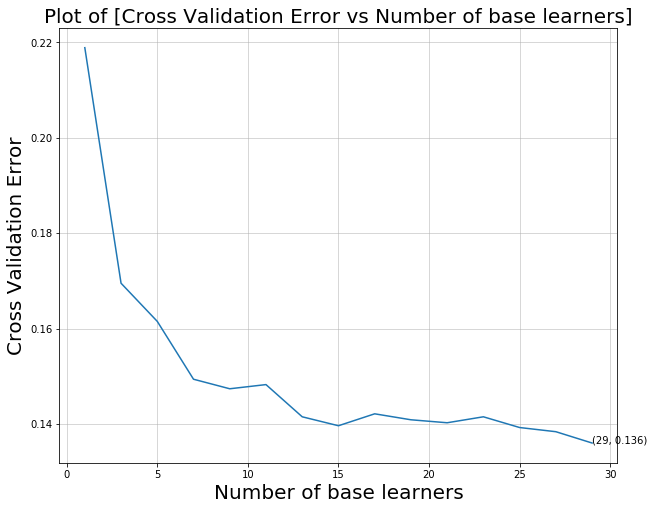

In [128]:
error = []
parameter = []
for i in range(len(scoreData)):
    error.append(1 - scoreData[i][1])
    parameter.append(scoreData[i][0]["n_estimators"])

plt.figure(figsize=(10,8))
plt.plot(parameter, error)

plt.title("Plot of [Cross Validation Error vs Number of base learners]", fontsize=20)
plt.xlabel("Number of base learners", fontsize=20)
plt.ylabel("Cross Validation Error", fontsize=20)
plt.grid(linestyle='-', linewidth=0.5)

errorMin = min(error)
errorMin

for xy in zip(parameter, error):
    if xy == (bp, errorMin):
        plt.annotate(xy, xy)

### Task 3. Apply Random Forest and report accuracy. Also check for train error.

In [129]:
#First checking for train error
model_rf_tr = RandomForestClassifier(n_estimators = bp, n_jobs = -1)

model_rf_tr.fit(train_AvgW2V, train_labels_AvgW2V)

prediction_AvgW2V_rf_tr = model_rf_tr.predict(train_AvgW2V)

AccuracyScore_AvgW2V_rf_tr = accuracy_score(train_labels_AvgW2V, prediction_AvgW2V_rf_tr)

print("Train error of Random Forest = "+str(np.round(((1 - AccuracyScore_AvgW2V_rf_tr) * 100), 4))+"%")

Train error of Random Forest = 0.1%


In [130]:
model_rf = RandomForestClassifier(n_estimators = bp, n_jobs = -1)

model_rf.fit(train_AvgW2V, train_labels_AvgW2V)

prediction_AvgW2V_rf = model_rf.predict(test_AvgW2V)

AccuracyScore_AvgW2V_rf = accuracy_score(test_labels_AvgW2V, prediction_AvgW2V_rf) * 100

print("Accuracy score of Random Forest = "+str(AccuracyScore_AvgW2V_rf)+"%")

Accuracy score of Random Forest = 85.25%


In [131]:
Confusion_Matrix = confusion_matrix(test_labels_AvgW2V, prediction_AvgW2V_rf)
print("Confusion Matrix on L2 regularization  \n"+str(Confusion_Matrix))

Confusion Matrix on L2 regularization  
[[  82  262]
 [  33 1623]]


In [132]:
tn, fp, fn, tp = confusion_matrix(test_labels_AvgW2V, prediction_AvgW2V_rf).ravel()
tn, fp, fn, tp

(82, 262, 33, 1623)

### Task 4. Perform GridSearch Cross Validation to find optimal number of base models and optimal value of depth of decision tree base models in XGBoost. 

In [31]:
xgb_model = xgb.XGBClassifier()

hyperParameters = {'max_depth':[1, 2, 3, 4], 'n_estimators':[30, 50, 70, 100]}

clf = GridSearchCV(estimator = xgb_model, param_grid = hyperParameters, scoring='accuracy', cv=3)
clf.fit(train_AvgW2V, train_labels_AvgW2V)

print(clf.best_estimator_)

C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning Fals

C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning Fals

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [32]:
best_parameter = clf.best_params_ 
best_parameter

{'max_depth': 4, 'n_estimators': 100}

In [33]:
scoreData = clf.grid_scores_
scoreData

[mean: 0.84350, std: 0.00012, params: {'max_depth': 1, 'n_estimators': 30},
 mean: 0.84613, std: 0.00072, params: {'max_depth': 1, 'n_estimators': 50},
 mean: 0.85037, std: 0.00078, params: {'max_depth': 1, 'n_estimators': 70},
 mean: 0.85525, std: 0.00086, params: {'max_depth': 1, 'n_estimators': 100},
 mean: 0.85200, std: 0.00186, params: {'max_depth': 2, 'n_estimators': 30},
 mean: 0.85650, std: 0.00204, params: {'max_depth': 2, 'n_estimators': 50},
 mean: 0.85800, std: 0.00450, params: {'max_depth': 2, 'n_estimators': 70},
 mean: 0.85825, std: 0.00455, params: {'max_depth': 2, 'n_estimators': 100},
 mean: 0.85588, std: 0.00390, params: {'max_depth': 3, 'n_estimators': 30},
 mean: 0.86087, std: 0.00615, params: {'max_depth': 3, 'n_estimators': 50},
 mean: 0.86038, std: 0.00522, params: {'max_depth': 3, 'n_estimators': 70},
 mean: 0.86075, std: 0.00586, params: {'max_depth': 3, 'n_estimators': 100},
 mean: 0.85975, std: 0.00527, params: {'max_depth': 4, 'n_estimators': 30},
 mean: 0.

In [34]:
error = []
eachError = []
for i in range(len(scoreData)):
    eachError.append(np.round((1 - scoreData[i][1]), 4))
    if i == 3 or i == 7 or i == 11 or i == 15:
        error.append(eachError)
        eachError = []

In [35]:
error

[[0.1565, 0.1539, 0.1496, 0.1448],
 [0.148, 0.1435, 0.142, 0.1418],
 [0.1441, 0.1391, 0.1396, 0.1392],
 [0.1402, 0.1391, 0.1371, 0.1349]]

In [36]:
columnNames = [30, 50, 70, 100]

In [37]:
errorFrame = pd.DataFrame(error, columns = columnNames)

In [38]:
errorFrame

,30,50,70,100
0,0.1565,0.1539,0.1496,0.1448
1,0.1480,0.1435,0.1420,0.1418
2,0.1441,0.1391,0.1396,0.1392
3,0.1402,0.1391,0.1371,0.1349


In [39]:
indexNames = [1, 2, 3, 4]
errorFrame["Max_depth"] = indexNames

In [40]:
errorFrame

,30,50,70,100,Max_depth
0,0.1565,0.1539,0.1496,0.1448,1
1,0.1480,0.1435,0.1420,0.1418,2
2,0.1441,0.1391,0.1396,0.1392,3
3,0.1402,0.1391,0.1371,0.1349,4


In [41]:
errorFrame.set_index("Max_depth", append = False, drop = True, inplace = True)

In [42]:
errorFrame

,30,50,70,100
Max_depth,,,,
1,0.1565,0.1539,0.1496,0.1448
2,0.1480,0.1435,0.1420,0.1418
3,0.1441,0.1391,0.1396,0.1392
4,0.1402,0.1391,0.1371,0.1349


Text(738.529,0.5,'Error')

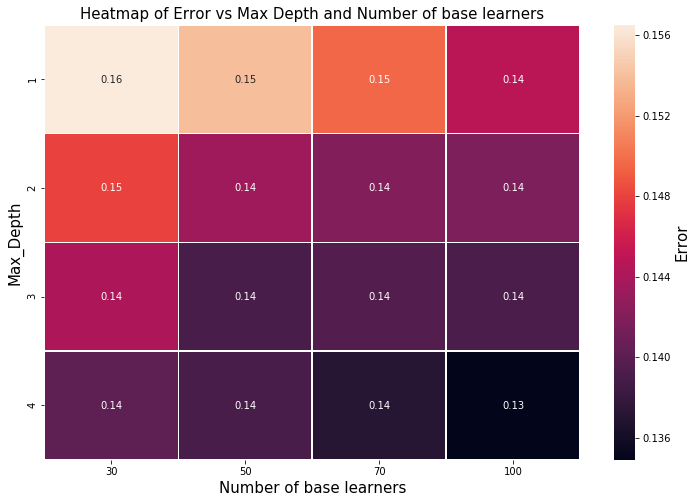

In [43]:
plt.figure(figsize=(12, 8))
plt.title("Heatmap of Error vs Max Depth and Number of base learners", size = 15)
ax = sns.heatmap(errorFrame, annot = True, linewidths=.5)
ax.figure.axes[0].set_xlabel('Number of base learners', size = 15)
ax.figure.axes[0].set_ylabel('Max_Depth', size = 15)
ax.figure.axes[-1].set_ylabel('Error', size = 15)

**Here above in heatmap you can see that the error is minimum when Number of base learners are 100 and Max_Depth value is 4. Therefore, from grid search we are considering our Number of base learners value as 100 and Max_Depth Value as 4.**

### Task 5. Apply XGBoost and report accuracy. Also check for train error.

In [45]:
#checking for train error
model_xg_tr = xgb.XGBClassifier(max_depth = 4, n_estimators = 100)

model_xg_tr.fit(train_AvgW2V, train_labels_AvgW2V)

prediction_AvgW2V_xg_tr = model_xg_tr.predict(train_AvgW2V)

AccuracyScore_AvgW2V_xg_tr = accuracy_score(train_labels_AvgW2V, prediction_AvgW2V_xg_tr)

print("Train Error of XGBoost = "+str((1 - AccuracyScore_AvgW2V_xg_tr) * 100)+"%")

Train Error of XGBoost = 8.1125%


C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [49]:
model_xg = xgb.XGBClassifier(max_depth = 4, n_estimators = 100)

model_xg.fit(train_AvgW2V, train_labels_AvgW2V)

prediction_xg = model_xg.predict(test_AvgW2V)

AccuracyScore_xg = accuracy_score(test_labels_AvgW2V, prediction_xg) * 100

print("Accuracy score of XGBoost = "+str(AccuracyScore_xg)+"%")

Accuracy score of XGBoost = 86.55000000000001%


C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [50]:
Confusion_Matrix = confusion_matrix(test_labels_AvgW2V, prediction_xg)
print("Confusion Matrix on L2 regularization  \n"+str(Confusion_Matrix))

Confusion Matrix on L2 regularization  
[[  79  213]
 [  56 1652]]


In [51]:
tn, fp, fn, tp = confusion_matrix(test_labels_AvgW2V, prediction_xg).ravel()
tn, fp, fn, tp

(79, 213, 56, 1652)

## 2. Average TFIDF-W2V.

In [150]:
tfidf_vect = TfidfVectorizer(ngram_range = (1,2))
tfidf = tfidf_vect.fit_transform(Data["ProcessedText"].values)

In [151]:
print(tfidf.shape)
print(type(tfidf))

(10000, 230778)
<class 'scipy.sparse.csr.csr_matrix'>


In [98]:
w2v_Model = gensim.models.Word2Vec(listOfSentences, size=300, min_count=5, workers=4)

In [152]:
# TF-IDF weighted Word2Vec
tfidf_features = tfidf_vect.get_feature_names()

tfidf_w2v = []
reviews = 0

for sentence in listOfSentences:
    sentenceVector = np.zeros(300)
    weightTfidfSum = 0
    for word in sentence:
        try:
            W2V_Vector = w2v_Model.wv[word]
            tfidfVector = tfidf[reviews, tfidf_features.index(word)]
            sentenceVector += (W2V_Vector * tfidfVector)
            weightTfidfSum += tfidfVector
        except:
            pass
    sentenceVector /= weightTfidfSum
    tfidf_w2v.append(sentenceVector)
    reviews += 1

### Task 1. Split train and test data in a ratio of 80:20.

In [153]:
X_train_TFIDF_W2V, X_test_TFIDF_W2V, Y_train_labels_TFIDF_W2V, Y_test_labels_TFIDF_W2V = train_test_split(tfidf_w2v, Data_Labels, test_size = 0.2)

In [154]:
train_TFIDF_W2V = np.array(X_train_TFIDF_W2V)
test_TFIDF_W2V = np.array(X_test_TFIDF_W2V)
train_labels_TFIDF_W2V = np.array(Y_train_labels_TFIDF_W2V)
test_labels_TFIDF_W2V = np.array(Y_test_labels_TFIDF_W2V)

In [155]:
train_TFIDF_W2V.shape, test_TFIDF_W2V.shape, train_labels_TFIDF_W2V.shape, test_labels_TFIDF_W2V.shape

((8000, 300), (2000, 300), (8000,), (2000,))

### Task 2. Perform GridSearch Cross Validation to find optimal value of number of base models in Random Forest.

In [156]:
values = []
for i in range(1, 31, 2):
    values.append(i)

clf = RandomForestClassifier(n_jobs = -1)

hyper_parameters = {'n_estimators': values}
bestScore = GridSearchCV(clf, hyper_parameters, scoring = "accuracy", cv = 3)
bestScore.fit(train_TFIDF_W2V, train_labels_TFIDF_W2V)

print(bestScore.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=19, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [157]:
best_parameter = bestScore.best_params_ 
bp = best_parameter["n_estimators"]
bp

19

In [158]:
scoreData = bestScore.grid_scores_
scoreData

[mean: 0.76875, std: 0.01000, params: {'n_estimators': 1},
 mean: 0.80850, std: 0.00427, params: {'n_estimators': 3},
 mean: 0.83462, std: 0.00339, params: {'n_estimators': 5},
 mean: 0.83425, std: 0.00236, params: {'n_estimators': 7},
 mean: 0.84462, std: 0.00230, params: {'n_estimators': 9},
 mean: 0.84588, std: 0.00193, params: {'n_estimators': 11},
 mean: 0.84975, std: 0.00361, params: {'n_estimators': 13},
 mean: 0.84688, std: 0.00181, params: {'n_estimators': 15},
 mean: 0.85037, std: 0.00317, params: {'n_estimators': 17},
 mean: 0.85362, std: 0.00073, params: {'n_estimators': 19},
 mean: 0.85275, std: 0.00297, params: {'n_estimators': 21},
 mean: 0.85137, std: 0.00131, params: {'n_estimators': 23},
 mean: 0.84888, std: 0.00280, params: {'n_estimators': 25},
 mean: 0.85125, std: 0.00277, params: {'n_estimators': 27},
 mean: 0.85362, std: 0.00154, params: {'n_estimators': 29}]

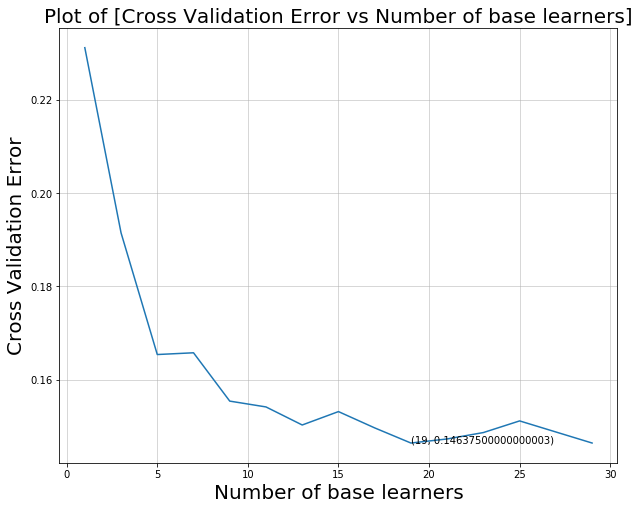

In [159]:
error = []
parameter = []
for i in range(len(scoreData)):
    error.append(1 - scoreData[i][1])
    parameter.append(scoreData[i][0]["n_estimators"])

plt.figure(figsize=(10,8))
plt.plot(parameter, error)

plt.title("Plot of [Cross Validation Error vs Number of base learners]", fontsize=20)
plt.xlabel("Number of base learners", fontsize=20)
plt.ylabel("Cross Validation Error", fontsize=20)
plt.grid(linestyle='-', linewidth=0.5)

errorMin = min(error)
errorMin

for xy in zip(parameter, error):
    if xy == (bp, errorMin):
        plt.annotate(xy, xy)

### Task 3. Apply Random Forest and report accuracy. Also check for train error.

In [160]:
#First checking for train error
model_rf_tr = RandomForestClassifier(n_estimators = bp, n_jobs = -1)

model_rf_tr.fit(train_TFIDF_W2V, train_labels_TFIDF_W2V)

prediction_TFIDF_W2V_rf_tr = model_rf_tr.predict(train_TFIDF_W2V)

AccuracyScore_TFIDF_W2V_rf_tr = accuracy_score(train_labels_TFIDF_W2V, prediction_TFIDF_W2V_rf_tr)

print("Train error of Random Forest = "+str(np.round(((1 - AccuracyScore_TFIDF_W2V_rf_tr) * 100), 4))+"%")

Train error of Random Forest = 0.225%


In [161]:
model_rf = RandomForestClassifier(n_estimators = bp, n_jobs = -1)

model_rf.fit(train_TFIDF_W2V, train_labels_TFIDF_W2V)

prediction_TFIDF_W2V_rf = model_rf.predict(test_TFIDF_W2V)

AccuracyScore_TFIDF_W2V_rf = accuracy_score(test_labels_TFIDF_W2V, prediction_TFIDF_W2V_rf) * 100

print("Accuracy score of Random Forest = "+str(AccuracyScore_TFIDF_W2V_rf)+"%")

Accuracy score of Random Forest = 84.1%


In [162]:
Confusion_Matrix = confusion_matrix(test_labels_TFIDF_W2V, prediction_TFIDF_W2V_rf)
print("Confusion Matrix on L2 regularization  \n"+str(Confusion_Matrix))

Confusion Matrix on L2 regularization  
[[  53  272]
 [  46 1629]]


In [163]:
tn, fp, fn, tp = confusion_matrix(test_labels_TFIDF_W2V, prediction_TFIDF_W2V_rf).ravel()
tn, fp, fn, tp

(53, 272, 46, 1629)

### Task 4. Perform GridSearch Cross Validation to find optimal number of base models and optimal value of depth of decision tree base models in XGBoost.

In [164]:
xgb_model = xgb.XGBClassifier()

hyperParameters = {'max_depth':[1, 2, 3, 4], 'n_estimators':[30, 50, 70, 100]}

clf = GridSearchCV(estimator = xgb_model, param_grid = hyperParameters, scoring='accuracy', cv=3)
clf.fit(train_TFIDF_W2V, train_labels_TFIDF_W2V)

print(clf.best_estimator_)

C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning Fals

C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning Fals

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=70,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [165]:
best_parameter = clf.best_params_ 
best_parameter

{'max_depth': 4, 'n_estimators': 70}

In [166]:
scoreData = clf.grid_scores_
scoreData

[mean: 0.84500, std: 0.00012, params: {'max_depth': 1, 'n_estimators': 30},
 mean: 0.84500, std: 0.00012, params: {'max_depth': 1, 'n_estimators': 50},
 mean: 0.84950, std: 0.00154, params: {'max_depth': 1, 'n_estimators': 70},
 mean: 0.85175, std: 0.00108, params: {'max_depth': 1, 'n_estimators': 100},
 mean: 0.84975, std: 0.00204, params: {'max_depth': 2, 'n_estimators': 30},
 mean: 0.85488, std: 0.00157, params: {'max_depth': 2, 'n_estimators': 50},
 mean: 0.85675, std: 0.00294, params: {'max_depth': 2, 'n_estimators': 70},
 mean: 0.85888, std: 0.00327, params: {'max_depth': 2, 'n_estimators': 100},
 mean: 0.85600, std: 0.00245, params: {'max_depth': 3, 'n_estimators': 30},
 mean: 0.85813, std: 0.00413, params: {'max_depth': 3, 'n_estimators': 50},
 mean: 0.85950, std: 0.00468, params: {'max_depth': 3, 'n_estimators': 70},
 mean: 0.86150, std: 0.00348, params: {'max_depth': 3, 'n_estimators': 100},
 mean: 0.85788, std: 0.00277, params: {'max_depth': 4, 'n_estimators': 30},
 mean: 0.

In [167]:
error = []
eachError = []
for i in range(len(scoreData)):
    eachError.append(np.round((1 - scoreData[i][1]), 4))
    if i == 3 or i == 7 or i == 11 or i == 15:
        error.append(eachError)
        eachError = []

In [168]:
error

[[0.155, 0.155, 0.1505, 0.1482],
 [0.1502, 0.1451, 0.1432, 0.1411],
 [0.144, 0.1419, 0.1405, 0.1385],
 [0.1421, 0.1391, 0.1359, 0.138]]

In [169]:
columnNames = [30, 50, 70, 100]

In [170]:
errorFrame = pd.DataFrame(error, columns = columnNames)

In [171]:
errorFrame

,30,50,70,100
0,0.1550,0.1550,0.1505,0.1482
1,0.1502,0.1451,0.1432,0.1411
2,0.1440,0.1419,0.1405,0.1385
3,0.1421,0.1391,0.1359,0.1380


In [172]:
indexNames = [1, 2, 3, 4]
errorFrame["Max_depth"] = indexNames

In [173]:
errorFrame

,30,50,70,100,Max_depth
0,0.1550,0.1550,0.1505,0.1482,1
1,0.1502,0.1451,0.1432,0.1411,2
2,0.1440,0.1419,0.1405,0.1385,3
3,0.1421,0.1391,0.1359,0.1380,4


In [174]:
errorFrame.set_index("Max_depth", append = False, drop = True, inplace = True)

In [175]:
errorFrame

,30,50,70,100
Max_depth,,,,
1,0.1550,0.1550,0.1505,0.1482
2,0.1502,0.1451,0.1432,0.1411
3,0.1440,0.1419,0.1405,0.1385
4,0.1421,0.1391,0.1359,0.1380


Text(738.529,0.5,'Error')

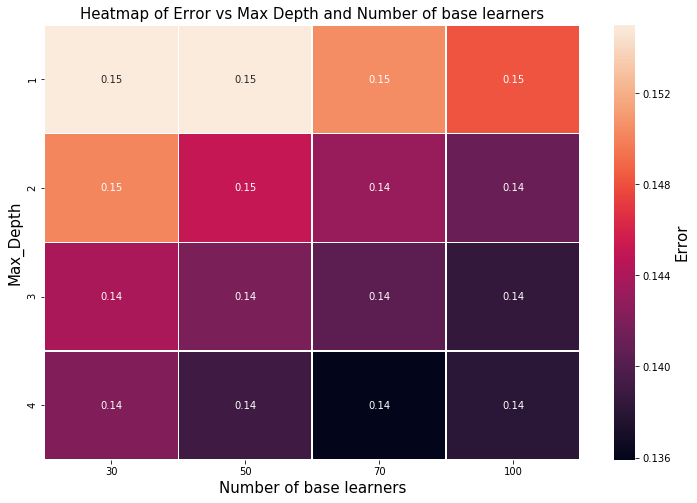

In [176]:
plt.figure(figsize=(12, 8))
plt.title("Heatmap of Error vs Max Depth and Number of base learners", size = 15)
ax = sns.heatmap(errorFrame, annot = True, linewidths=.5)
ax.figure.axes[0].set_xlabel('Number of base learners', size = 15)
ax.figure.axes[0].set_ylabel('Max_Depth', size = 15)
ax.figure.axes[-1].set_ylabel('Error', size = 15)

**Here above in heatmap you can see that the error is minimum when Number of base learners are 70 and Max_Depth value is 4. Therefore, from grid search we are considering our Number of base learners value as 70 and Max_Depth Value as 4.**

### Task 5. Apply XGBoost and report accuracy. Also check for train error.

In [177]:
#checking for train error
model_xg_tr = xgb.XGBClassifier(max_depth = 4, n_estimators = 70)

model_xg_tr.fit(train_TFIDF_W2V, train_labels_TFIDF_W2V)

prediction_TFIDF_W2V_xg_tr = model_xg_tr.predict(train_TFIDF_W2V)

AccuracyScore_TFIDF_W2V_xg_tr = accuracy_score(train_labels_TFIDF_W2V, prediction_TFIDF_W2V_xg_tr)

print("Train Error of XGBoost = "+str((1 - AccuracyScore_TFIDF_W2V_xg_tr) * 100)+"%")

Train Error of XGBoost = 10.099999999999998%


C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [179]:
model_xg = xgb.XGBClassifier(max_depth = 4, n_estimators = 70)

model_xg.fit(train_TFIDF_W2V, train_labels_TFIDF_W2V)

prediction_xg = model_xg.predict(test_TFIDF_W2V)

AccuracyScore_xg = accuracy_score(test_labels_TFIDF_W2V, prediction_xg) * 100

print("Accuracy score of XGBoost = "+str(AccuracyScore_xg)+"%")

Accuracy score of XGBoost = 84.65%


C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [180]:
Confusion_Matrix = confusion_matrix(test_labels_TFIDF_W2V, prediction_xg)
print("Confusion Matrix on L2 regularization  \n"+str(Confusion_Matrix))

Confusion Matrix on L2 regularization  
[[  64  261]
 [  46 1629]]


In [181]:
tn, fp, fn, tp = confusion_matrix(test_labels_TFIDF_W2V, prediction_xg).ravel()
tn, fp, fn, tp

(64, 261, 46, 1629)

## Summary

### Avg W2V
**1. Optimal Value of number of base learners in Random Forest from Grid Search = 29**<br>
**2. Train Error in Random Forest  = 0.1%**<br>
**3. Accuracy of Random Forest = 85.25%**<br>
**4. Optimal Value of number of base learners and maximum depth of base learners in XGBoost from Grid Search = 100 & 4**<br>
**5. Train Error in XGBoost 8.11%**<br>
**6. Accuracy of XGBoost = 86.55%**<br>
### TFIDF-W2V
**1. Optimal Value of number of base learners in Random Forest from Grid Search = 19**<br>
**2. Train Error in Random Forest  = 0.225%**<br>
**3. Accuracy of Random Forest = 84.1%**<br>
**4. Optimal Value of number of base learners and maximum depth of base learners in XGBoost from Grid Search = 70 & 4**<br>
**5. Train Error in XGBoost 10.09%**<br>
**6. Accuracy of XGBoost = 84.65%**<br>